In [60]:
import numpy as np
import pandas as pd
import scipy
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import curve_fit
from fbprophet import Prophet
from fbprophet import Prophet
from scipy.stats import boxcox
from multiprocessing import Pool, cpu_count
import tqdm
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import re, string, timeit
from xgboost import plot_importance
from gensim.models import Word2Vec 
sns.set(style="darkgrid")

%matplotlib inline

In [61]:
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
sales_tr = pd.read_csv('sales_train_v2.csv')
test_df = pd.read_csv('test.csv')

In [62]:
print ('shops in train not in test is', set(sales_tr['shop_id']) - set(test_df['shop_id']))
print ('shops in test not in train is ', set(test_df['shop_id']) - set(sales_tr['shop_id']))

val1 = set(sales_tr['item_id']) - set(test_df['item_id'])
val2 = set(test_df['item_id']) - set(sales_tr['item_id'])
print ('items in train not in test is', list(val1)[:10])
print ('count of items in train not in test is', len(list(val1)))
print ('count of items in test not in train is', len(list(val2)))


shops in train not in test is {0, 1, 32, 33, 8, 9, 40, 11, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}
shops in test not in train is  set()
items in train not in test is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
count of items in train not in test is 17070
count of items in test not in train is 363


In [63]:
days_per_month = pd.Series({0:31, 1:28, 2: 31, 3: 30, 4: 31, 5: 30, 6: 31, 7: 31, 8: 30, 9: 31, 10: 30, 11: 30})

In [66]:
offer_times = sales_tr.groupby(['item_id', 'shop_id'], as_index=False)['item_price'].count()

In [64]:
sales_tr.head()
sales_tr = sales_tr[sales_tr['item_price'] < 10000]
sales_tr = sales_tr[sales_tr['item_cnt_day'] < 600]
#sales_tr['item_cnt_day'] = sales_tr['item_cnt_day'].clip(0,100)

In [65]:
sales_tr.loc[sales_tr.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_tr.loc[sales_tr.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_tr.loc[sales_tr.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

In [7]:
matrix = sales_tr.groupby(['date_block_num', 'item_id', 'shop_id'], as_index=False).agg({'item_price': {'count_prices': 'count'}, 'item_cnt_day': 'sum'})
matrix.columns = ['date_block_num', 'item_id', 'shop_id',  'count_prices', 'item_cnt_month']
matrix.loc[matrix['item_cnt_month'] < 0, 'item_cnt_month'] = 0
matrix['ID'] = -1


C:\programs\envs\kaggle\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [8]:
matrix.shape

(1600374, 6)

In [9]:
test_df['item_cnt_month'] = 0
test_df['date_block_num'] = 34

In [10]:
test_df.shape

(214200, 5)

In [11]:
matrix = pd.concat([matrix, test_df], axis=0, sort=True)

In [12]:
shops = shops.sort_values(by=['shop_name'])
shops['city'] = shops['shop_name'].str.split(' ').apply(lambda x: x[0].strip())
shops.loc[(shops['city'] == u'!Якутск'), 'city'] = u'Якутск'
#shops['city'] = shops['city'].factorize()[0]
shops['city'] = LabelEncoder().fit_transform(shops['city'])

shops['shop_type']  = shops['shop_name'].str.split(' ').apply(lambda x: '_'.join([re.sub(r'[^\w\s]','',t) for t in x[1:2]]))
shops['shop_type'] = LabelEncoder().fit_transform(shops['shop_type'])
shops['shop_lname'] = shops['shop_name'].str.split(' ').apply(lambda x: '_'.join([re.sub(r'[^\w\s]','',t) for t in x[2:]]))
shops['shop_lname'] = LabelEncoder().fit_transform(shops['shop_lname'])

In [13]:
item_cat = item_cat.sort_values(by=['item_category_name'])
item_cat['item_cat_level1'] = item_cat['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
#item_cat['item_cat_level1'] = item_cat['item_cat_level1'].factorize()[0]
item_cat['item_cat_level1'] = LabelEncoder().fit_transform(item_cat['item_cat_level1'])

item_cat['item_cat_level2'] = item_cat['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
#item_cat['item_cat_level2'] = item_cat['item_cat_level2'].factorize()[0]
item_cat['item_cat_level2'] = LabelEncoder().fit_transform(item_cat['item_cat_level2'])

#item_cat['item_category_name'] = item_cat['item_category_name'].factorize()[0]

In [14]:
item_cat.head()

,item_category_name,item_category_id,item_cat_level1,item_cat_level2
0,PC - Гарнитуры/Наушники,0,0,0
1,Аксессуары - PS2,1,1,1
2,Аксессуары - PS3,2,1,1
3,Аксессуары - PS4,3,1,1
4,Аксессуары - PSP,4,1,1


In [15]:
matrix.shape

(1814574, 6)

In [16]:
print (matrix.shape)

matrix = pd.merge(matrix, shops, left_on='shop_id', right_on='shop_id', how='left')
print (matrix.shape)
matrix = pd.merge(matrix, items, left_on='item_id', right_on='item_id', how='left')
print (matrix.shape)
matrix = pd.merge(matrix, item_cat, left_on='item_category_id', right_on='item_category_id', how='left')
print (matrix.shape)
matrix['month'] =  (matrix['date_block_num'])%12
matrix['days_per_month'] = matrix['month'].map(days_per_month)

(1814574, 6)
(1814574, 10)
(1814574, 12)
(1814574, 15)


In [17]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1814574 entries, 0 to 1814573
Data columns (total 17 columns):
ID                    int64
count_prices          float64
date_block_num        int64
item_cnt_month        float64
item_id               int64
shop_id               int64
shop_name             object
city                  int32
shop_type             int32
shop_lname            int32
item_name             object
item_category_id      int64
item_category_name    object
item_cat_level1       int32
item_cat_level2       int32
month                 int64
days_per_month        int64
dtypes: float64(2), int32(5), int64(7), object(3)
memory usage: 214.6+ MB


In [18]:

matrix.ID = matrix.ID.astype('int64')
matrix.date_block_num = matrix.date_block_num.astype('uint8')
matrix.item_cnt_month = matrix.item_cnt_month.astype('int16')
matrix.item_id = matrix.item_id.astype('int16')
matrix.shop_id = matrix.shop_id.astype('int16')
matrix.item_category_id = matrix.item_category_id.astype('float16')
matrix.days_per_month = matrix.days_per_month.astype('float16')
matrix.item_cat_level1 = matrix.item_cat_level1.astype('float16')
matrix.item_cat_level2 = matrix.item_cat_level2.astype('float16')


In [19]:
# construct item_id, shop_id sales matrix
sales_matrix = matrix.groupby(['item_id', 'shop_id'])['item_cnt_month'].sum().unstack('shop_id')

shop_id_sales_me_na = sales_matrix.mean(axis=0)
shop_id_sales_me_z = sales_matrix.fillna(0).mean(axis=0)
item_id_sales_me_na = sales_matrix.mean(axis=1)
item_id_sales_me_z = sales_matrix.fillna(0).mean(axis=1)


# mean encoding for shop id based on sales
matrix['m_shop_id_sales_me_na'] = matrix['shop_id'].map(shop_id_sales_me_na)
matrix['m_shop_id_sales_me_z'] = matrix['shop_id'].map(shop_id_sales_me_z)

# mean encoding for item_id based on sales
matrix['m_item_id_sales_me_na'] = matrix['item_id'].map(item_id_sales_me_na)
matrix['m_item_id_sales_me_z'] = matrix['item_id'].map(item_id_sales_me_z)

del sales_matrix
del shop_id_sales_me_na
del shop_id_sales_me_z
del item_id_sales_me_na
del item_id_sales_me_z

In [20]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [21]:
matrix = lag_feature(matrix, [1], 'item_cnt_month')

In [22]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1814574 entries, 0 to 1814573
Data columns (total 22 columns):
ID                       int64
count_prices             float64
date_block_num           uint8
item_cnt_month           int16
item_id                  int16
shop_id                  int16
shop_name                object
city                     int32
shop_type                int32
shop_lname               int32
item_name                object
item_category_id         float16
item_category_name       object
item_cat_level1          float16
item_cat_level2          float16
month                    int64
days_per_month           float16
m_shop_id_sales_me_na    float64
m_shop_id_sales_me_z     float64
m_item_id_sales_me_na    float64
m_item_id_sales_me_z     float64
item_cnt_month_lag_1     float64
dtypes: float16(4), float64(6), int16(3), int32(3), int64(2), object(3), uint8(1)
memory usage: 212.9+ MB


In [23]:
group = matrix.groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'shop_id', 'mean_shop_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'shop_id'], right_on=['date_block_num', 'shop_id'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_shop_sales')
print (matrix.shape)

(1814574, 23)
(1814574, 24)


In [24]:
group = matrix.groupby(['date_block_num', 'item_category_id'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'item_category_id', 'mean_item_cat_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'item_category_id'], right_on=['date_block_num', 'item_category_id'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_item_cat_sales')
print (matrix.shape)

(1814574, 25)
(1814574, 26)


In [25]:
group = matrix.groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'item_id', 'mean_item_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'item_id'], right_on=['date_block_num', 'item_id'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_item_sales')
print (matrix.shape)

(1814574, 27)
(1814574, 28)


In [26]:
group = matrix.groupby(['date_block_num', 'item_id', 'city'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'item_id', 'city', 'mean_item_city_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'item_id', 'city'], right_on=['date_block_num', 'item_id', 'city'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_item_city_sales')
print (matrix.shape)

(1814574, 29)
(1814574, 30)


In [27]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_type'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'item_id', 'shop_type', 'mean_item_shop_type_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'item_id', 'shop_type'], right_on=['date_block_num', 'item_id', 'shop_type'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_item_shop_type_sales')
print (matrix.shape)

(1814574, 31)
(1814574, 32)


In [28]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_lname'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'item_id', 'shop_lname', 'mean_item_shop_lname_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'item_id', 'shop_lname'], right_on=['date_block_num', 'item_id', 'shop_lname'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_item_shop_lname_sales')
print (matrix.shape)

(1814574, 33)
(1814574, 34)


In [29]:
group = matrix.groupby(['date_block_num', 'shop_id', 'city'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'shop_id', 'city', 'mean_shop_city_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'shop_id', 'city'], right_on=['date_block_num', 'shop_id', 'city'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_shop_city_sales')
print (matrix.shape)

(1814574, 35)
(1814574, 36)


In [30]:
group = matrix.groupby(['date_block_num', 'shop_type'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'shop_type', 'mean_shop_type_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'shop_type'], right_on=['date_block_num', 'shop_type'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_shop_type_sales')
print (matrix.shape)

(1814574, 37)
(1814574, 38)


In [31]:
group = matrix.groupby(['date_block_num', 'shop_lname'], as_index=False)['item_cnt_month'].mean()
group.columns = ['date_block_num', 'shop_lname', 'mean_shop_lname_sales']
matrix = pd.merge(matrix, group, left_on = ['date_block_num', 'shop_lname'], right_on=['date_block_num', 'shop_lname'], how='left')
print (matrix.shape)

matrix = lag_feature(matrix, [1], 'mean_shop_lname_sales')
print (matrix.shape)

(1814574, 39)
(1814574, 40)


In [32]:
matrix.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

In [33]:
#matrix = matrix[matrix.date_block_num > 11]

In [34]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

matrix = fill_na(matrix)

In [35]:
X_train = matrix[ (matrix.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = matrix[ (matrix.date_block_num < 33)]['item_cnt_month']

X_valid = matrix[(matrix.date_block_num == 33) ].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[(matrix.date_block_num == 33) ]['item_cnt_month']

X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [36]:
model = XGBRegressor(
    max_depth=4,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.6,
    eta=0.3,
    reg_lambda=2,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)


[0]	validation_0-rmse:7.72697	validation_1-rmse:6.62181
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:7.04837	validation_1-rmse:6.03655
[2]	validation_0-rmse:6.43308	validation_1-rmse:5.51292
[3]	validation_0-rmse:5.86544	validation_1-rmse:5.04221
[4]	validation_0-rmse:5.36563	validation_1-rmse:4.60448
[5]	validation_0-rmse:4.92918	validation_1-rmse:4.14023
[6]	validation_0-rmse:4.51473	validation_1-rmse:3.80988
[7]	validation_0-rmse:4.14022	validation_1-rmse:3.43696
[8]	validation_0-rmse:3.82163	validation_1-rmse:3.10333
[9]	validation_0-rmse:3.52034	validation_1-rmse:2.82334
[10]	validation_0-rmse:3.23968	validation_1-rmse:2.62026
[11]	validation_0-rmse:2.99794	validation_1-rmse:2.43986
[12]	validation_0-rmse:2.80481	validation_1-rmse:2.25472
[13]	validation_0-rmse:2.59551	validation_1-rmse:2.0889
[14]	validation_0-rmse:2.40776	validation_1-rmse:1.9572

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0.5, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=2, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.6)

In [37]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

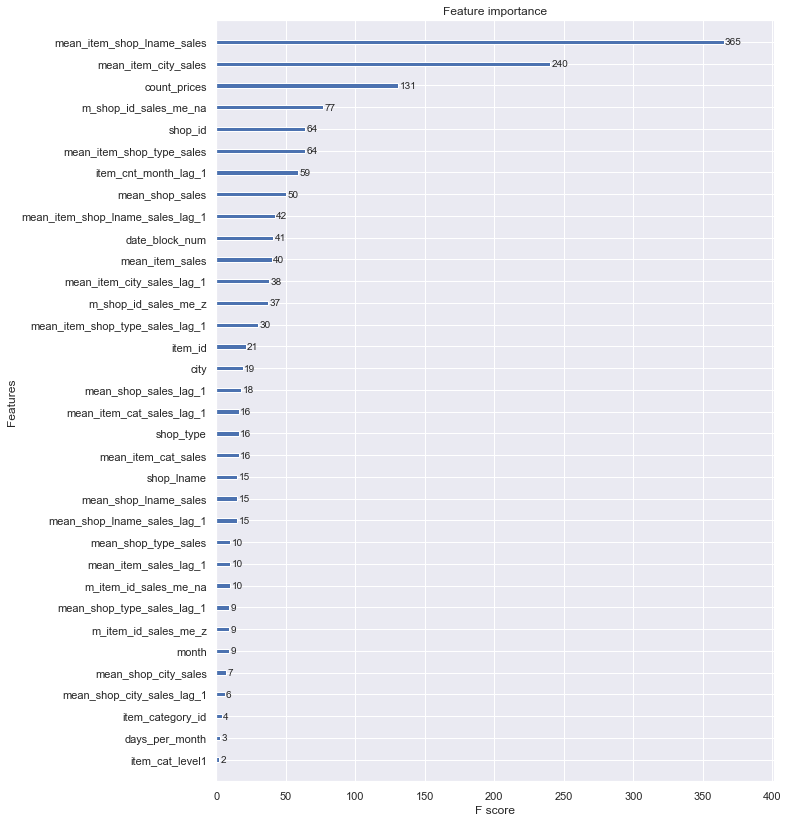

In [38]:
plot_features(model, (10,14))


In [39]:
Y_pred = model.predict(X_valid).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
cat_cols = ['date_block_num', 
            'item_id',
            'shop_id', 
            'city', 
            'item_category_id',
            'item_cat_level1', 
            'item_cat_level2', 
            'month']

cat_mat = matrix[cat_cols]

In [ ]:
for col in cat_cols:
    cat_mat[col] = '{0}_'.format(col) + cat_mat[col].astype(str)


In [ ]:
def gen_cat2vec_sentences(data):
    X_w2v = data.copy()
    names = list(X_w2v.columns.values)
    for c in names:
        X_w2v[c] = X_w2v[c].fillna('unknow').astype('category')
        X_w2v[c].cat.categories = ["%s %s" % (c,g) for g in X_w2v[c].cat.categories]
    X_w2v = X_w2v.values.tolist()
    return X_w2v

In [ ]:
n_cat2vec_feature  = 20 # define the cat2vecs dimentions
n_cat2vec_window   = len(cat_cols) * 2 # define the w2v window size

In [ ]:
from random import shuffle

def fit_cat2vec_model():
    X_w2v = gen_cat2vec_sentences(cat_mat)
    for i in X_w2v:
        shuffle(i)
    model = Word2Vec(X_w2v, size=n_cat2vec_feature, window=n_cat2vec_window)
    return model

print('Fit cat2vec model')
c2v_model = fit_cat2vec_model()

In [ ]:
def apply_w2v(sentences, model, num_features):
    def _average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        n_words = 0.
        for word in words:
            if word in vocabulary: 
                n_words = n_words + 1.
                feature_vector = np.add(feature_vector, model[word])

        if n_words:
            feature_vector = np.divide(feature_vector, n_words)
        return feature_vector
    
    vocab = set(model.wv.index2word)
    feats = [_average_word_vectors(s, model, vocab, num_features) for s in sentences]
    return np.array(feats)

In [ ]:
c2v_matrix = apply_w2v(gen_cat2vec_sentences(cat_mat), c2v_model, n_cat2vec_feature)

In [ ]:
c2v_matrix.shape

In [ ]:
matrix.shape

In [ ]:
matrix2 = pd.concat([matrix, pd.DataFrame(c2v_matrix, columns = [f'c2v_{col}' for col in range(c2v_matrix.shape[1])])], axis=1)

In [ ]:
X_train = matrix2[ (matrix2.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = matrix2[ (matrix2.date_block_num < 33)]['item_cnt_month']
X_valid = matrix2[matrix2.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix2[matrix2.date_block_num == 33]['item_cnt_month']
X_test = matrix2[matrix2.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
model = XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=50, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


In [ ]:
plot_features(model, (10,14))


In [40]:
test_df

,ID,shop_id,item_id,item_cnt_month,date_block_num
0,0,5,5037,0,34
1,1,5,5320,0,34
2,2,5,5233,0,34
3,3,5,5232,0,34
4,4,5,5268,0,34
5,5,5,5039,0,34
6,6,5,5041,0,34
7,7,5,5046,0,34
8,8,5,5319,0,34
9,9,5,5003,0,34


In [59]:
X_test['count_prices']

1600374    1.822136
1600375    1.822136
1600376    1.822136
1600377    1.822136
1600378    1.822136
1600379    1.822136
1600380    1.822136
1600381    1.822136
1600382    1.822136
1600383    1.822136
1600384    1.822136
1600385    1.822136
1600386    1.822136
1600387    1.822136
1600388    1.822136
1600389    1.822136
1600390    1.822136
1600391    1.822136
1600392    1.822136
1600393    1.822136
1600394    1.822136
1600395    1.822136
1600396    1.822136
1600397    1.822136
1600398    1.822136
1600399    1.822136
1600400    1.822136
1600401    1.822136
1600402    1.822136
1600403    1.822136
             ...   
1814544    1.822136
1814545    1.822136
1814546    1.822136
1814547    1.822136
1814548    1.822136
1814549    1.822136
1814550    1.822136
1814551    1.822136
1814552    1.822136
1814553    1.822136
1814554    1.822136
1814555    1.822136
1814556    1.822136
1814557    1.822136
1814558    1.822136
1814559    1.822136
1814560    1.822136
1814561    1.822136
1814562    1.822136


item_id  shop_id
30       2          1
         3          1
         4          1
         5          1
         6          1
         7          1
         10         1
         12         1
         14         1
         15         1
         16         1
         18         1
         19         1
         21         1
         22         1
         24         1
         25         1
         26         1
         28         1
         31         1
         34         1
         35         1
         36         1
         37         1
         38         1
         39         1
         41         1
         42         1
         44         1
         45         1
                   ..
22167    19         1
         21         1
         22         1
         24         1
         25         1
         26         1
         28         1
         31         1
         34         1
         35         1
         36         1
         37         1
         38         1
         39    